# Wine Quality Classifier

##### LOAD THE FEATURE DATA

In [1]:
import pandas as pd
import numpy as np

X = pd.read_csv('../../../data/preprocessed_data/X.csv', sep=',')

print ('Feature data, shape:\nX: {}'.format(X.shape))
X.head()

Feature data, shape:
X: (178, 13)


,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [2]:
y = pd.read_csv('../../../data/preprocessed_data/y.csv', sep=',')

print ('Target data, shape:\ny: {}'.format(X.shape))
y.head()

Target data, shape:
y: (178, 13)


,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


##### SPLIT THE DATA

In [3]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=13)

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(X_train.shape,
                                                                    y_train.shape,
                                                                    X_test.shape,
                                                                    y_test.shape))

Data shapes:

X_train : (142, 13)
y_train : (142, 3)

X_test : (36, 13)
y_test : (36, 3)


##### DEFINE NETWORK PARAMETERS

In [4]:
# define number of attributes
n_features = X_train.shape[1]    
n_classes = y_train.shape[1]

# count number of samples in each set of data
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# define amount of neurons
n_layer_in = n_features  # 11 neurons in input layer
n_layer_h1 = 50          # first   hidden layer
n_layer_h2 = 50          # second  hidden layer
n_layer_out = n_classes  # 7 neurons in input layer

sigma_init = 0.01   # For randomized initialization

##### RESET TENSORFLOW GRAPH IF THERE IS ANY

In [5]:
import tensorflow as tf

# this will set up a specific seed in order to control the output 
# and get more homogeneous results though every model variation
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

##### MODEL ARCHITECTURE

In [6]:
# create symbolic variables
X = tf.placeholder(tf.float32, [None, n_features], name="input")
Y = tf.placeholder(tf.float32, [None, n_classes], name="output")

# deploy the variables that will store the weights
W = {
    'W1': tf.Variable(tf.random_normal([n_layer_in, n_layer_h1], stddev = sigma_init), name='W1'),
    'W2': tf.Variable(tf.random_normal([n_layer_h1, n_layer_h2], stddev = sigma_init), name='W2'),
    'W3': tf.Variable(tf.random_normal([n_layer_h2, n_layer_out], stddev = sigma_init), name='W3'),
}

# deploy the variables that will store the bias
b = {
    'b1': tf.Variable(tf.random_normal([n_layer_h1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_layer_h2]), name='b2'),
    'b3': tf.Variable(tf.random_normal([n_layer_out]), name='b3'),
}

# this will create the model architecture and enable dropout on the hidden layers
# in order to avoid overfitting the training accuracy
keep_prob = 1

def model_MLP(_X, _W, _b):
    with tf.name_scope('hidden_1'):
        layer_h1 = tf.nn.relu(tf.add(tf.matmul(_X,_W['W1']), _b['b1']))
        #layer_h1 = tf.nn.dropout(layer_h1, keep_prob)
        
    with tf.name_scope('hidden_2'):
        layer_h2 = tf.nn.relu(tf.add(tf.matmul(layer_h1,_W['W2']), _b['b2']))
        #layer_h2 = tf.nn.dropout(layer_h2, keep_prob)
        
    with tf.name_scope('layer_output'):
        layer_out = tf.nn.softmax(tf.add(tf.matmul(layer_h2,_W['W3']), _b['b3']))
        return layer_out
    
with tf.name_scope("MLP"):
    y_pred = model_MLP(X, W, b)
    

##### DEFINE LEARNING RATE

In [7]:
learning_rate = 0.10

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'none'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.10
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

Decaying Learning Rate :  none


##### DEFINE MODEL TRAINING AND MEASURE PERFORMANCE
If X only has one column (one variable) don't use tf.reduce_mean in the definition of the loss function

In Mathematics, Logitis a function that is used to maps probabilities ( [0, 1] ) to R ( (-inf, inf) ) .

A logits of 0 corresponds to a probability of 0.5.

A negative logit corresponds to a probability of less than 0.5.

A positive logit corresponds to a probability greater than 0.5.

In ML, logits can be defined as a vector of raw predictions that a classification model generates and it is passed to a normalized function. In case the model is solving a classification problem having multiple class, logits will behave as an input to the softmax function. Then the softmax function generates a vector of probability having one value for each class. Logits sometime also refer to the element-wise inverse of the sigmoid function.
https://intellipaat.com/community/500/what-is-the-meaning-of-the-word-logits-in-tensorflow

In [8]:
with tf.name_scope("loss"):
    #loss = tf.square(Y - y_pred)                                                       # squared error
    #loss = tf.nn.softmax(logits=y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_pred, dim=-1) # cross-entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_pred)     # sparse-softmax-cross-entropy
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    #optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    

# Create summaries
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar("learn_rate", learning_rate)

# Merge all summaries into a single op to generate the summary data
merged_summary_op = tf.summary.merge_all()

##### EXECUTE THE MODEL

In [9]:
from datetime import datetime

# define some parameters
n_epochs = 150
display_epoch = 10
batch_size = 10
n_batches = int(n_train/batch_size)

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

# this will later help me to restore the model to a specific epoch
saver = tf.train.Saver(tf.global_variables())

# store results through every epoch iteration
acc_train_list = []
acc_test_list = []
avg_loss_list = []
learning_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # write logs for tensorboard
    summary_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
    
    for epoch in range(1, n_epochs+1):
        avg_loss = 0    # store batches' average loss
        
        for i in range(0, n_train, batch_size):
            # create batches
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # start model training
            sess.run(training_op, feed_dict={X:X_batch, Y:y_batch})
            
            
            # Run optimization (backprop), cost and summary nodes
            _, _loss, _summary = sess.run([training_op, loss, merged_summary_op],
                                          feed_dict={X:X_batch, Y:y_batch})
            avg_loss += _loss/n_batches
            
            # Write logs at every iteration
            summary_writer.add_summary(_summary, epoch * n_batches + i)
            
        # after the epoch is finished this will append the loss
        avg_loss_list.append(avg_loss)
            
        # measure performance and display the results
        if (epoch+1) % display_epoch == 0:
            _acc_train = accuracy.eval({X: X_train, Y:y_train})
            _acc_test = accuracy.eval(feed_dict={X: X_test, Y: y_test})
            
            # append results to lists
            acc_train_list.append(_acc_train); acc_test_list.append(_acc_test)
            learning_list.append(sess.run(learning_rate))

            # Save model weights to disk for reproducibility
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess, "tf_checkpoints/epoch{:04}.ckpt".format((epoch+1)))
            
            print("Epoch: {:04}\tTrainAcc: {:06.5f}\tTestAcc: {:06.5f}\tLoss: {:06.5f}\tLearning: {:06.7f}".format((epoch+1),
                                                                                                                   _acc_train,
                                                                                                                   _acc_test,
                                                                                                                   avg_loss,
                                                                                                                   sess.run(learning_rate)))
            
    # store the predicted values
    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    print('\nPrinting network raw output \n\n', predictions)
    predictions = tf.argmax(predictions, 1).eval()
    
    # output comparative table
    dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    dataframe['Target'] = np.argmax(y_test, 1)
    dataframe['Hit'] = np.equal(dataframe.Target, dataframe.Prediction)
    print('\n\nPrinting results :\n\n', dataframe)

Epoch: 0010	TrainAcc: 0.39437	TestAcc: 0.41667	Loss: 0.81159	Learning: 0.1000000
Epoch: 0020	TrainAcc: 0.39437	TestAcc: 0.41667	Loss: 0.81144	Learning: 0.1000000
Epoch: 0030	TrainAcc: 0.39437	TestAcc: 0.41667	Loss: 0.81067	Learning: 0.1000000
Epoch: 0040	TrainAcc: 0.39437	TestAcc: 0.41667	Loss: 0.80266	Learning: 0.1000000
Epoch: 0050	TrainAcc: 0.72535	TestAcc: 0.75000	Loss: 0.71426	Learning: 0.1000000
Epoch: 0060	TrainAcc: 0.90141	TestAcc: 0.88889	Loss: 0.66177	Learning: 0.1000000
Epoch: 0070	TrainAcc: 0.99296	TestAcc: 0.94444	Loss: 0.62417	Learning: 0.1000000
Epoch: 0080	TrainAcc: 1.00000	TestAcc: 0.97222	Loss: 0.61391	Learning: 0.1000000
Epoch: 0090	TrainAcc: 1.00000	TestAcc: 0.97222	Loss: 0.61066	Learning: 0.1000000
Epoch: 0100	TrainAcc: 1.00000	TestAcc: 0.97222	Loss: 0.60930	Learning: 0.1000000
Epoch: 0110	TrainAcc: 1.00000	TestAcc: 0.97222	Loss: 0.60862	Learning: 0.1000000
Epoch: 0120	TrainAcc: 1.00000	TestAcc: 0.97222	Loss: 0.60823	Learning: 0.1000000
Epoch: 0130	TrainAcc: 1.0000

##### VISUALIZE THE RESULTS

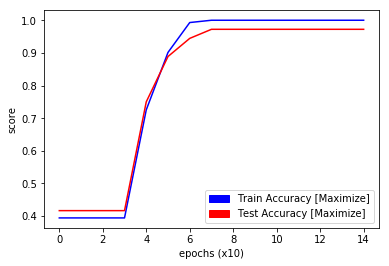

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

#plot the data
plt.plot(acc_train_list, color='blue')
plt.plot(acc_test_list, color='red')

plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('score');

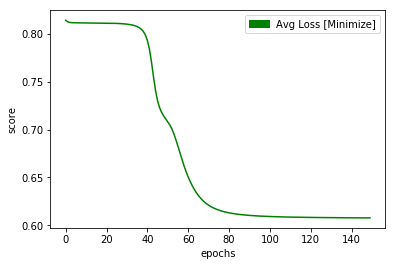

In [11]:
# set up legend
green_patch = mpatches.Patch(color='green', label='Avg Loss [Minimize]')
plt.legend(handles=[green_patch])

#plot the data
plt.plot(avg_loss_list, color='green')

plt.xlabel('epochs')
plt.ylabel('score');

##### LEARNING RATE EVOLUTION

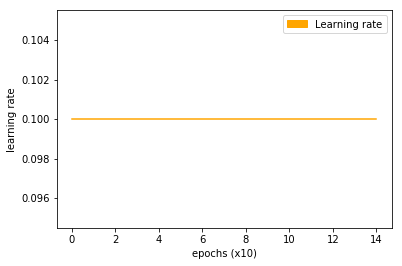

In [12]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(learning_list, color='orange');
plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('learning rate');

##### VISUALIZE TENSORBOARD

In [13]:
'''
from IPython.display import clear_output, Image, display, HTML

#   CHECK IT ON TENSORBOARD TYPING THESE LINES IN THE COMMAND PROMPT:
#   tensorboard --logdir=/tmp/tf_logs

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph())
'''

'\nfrom IPython.display import clear_output, Image, display, HTML\n\n#   CHECK IT ON TENSORBOARD TYPING THESE LINES IN THE COMMAND PROMPT:\n#   tensorboard --logdir=/tmp/tf_logs\n\ndef strip_consts(graph_def, max_const_size=32):\n    """Strip large constant values from graph_def."""\n    strip_def = tf.GraphDef()\n    for n0 in graph_def.node:\n        n = strip_def.node.add() \n        n.MergeFrom(n0)\n        if n.op == \'Const\':\n            tensor = n.attr[\'value\'].tensor\n            size = len(tensor.tensor_content)\n            if size > max_const_size:\n                tensor.tensor_content = b"<stripped %d bytes>"%size\n    return strip_def\n\ndef show_graph(graph_def, max_const_size=32):\n    """Visualize TensorFlow graph."""\n    if hasattr(graph_def, \'as_graph_def\'):\n        graph_def = graph_def.as_graph_def()\n    strip_def = strip_consts(graph_def, max_const_size=max_const_size)\n    code = """\n        <script>\n          function load() {{\n            document.g

##### RESTORE TO CHECKPOINT

In [14]:
'''
# select the epoch to be restored
epoch = 30

# Running a new session
print('Restoring model to Epoch {}\n'.format(epoch))


with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Restore model weights from previously saved model
    checkpoint = tf.train.import_meta_graph('tf_checkpoints/epoch{:04}.ckpt.meta'.format(epoch))
    #checkpoint.restore(sess, 'tf_checkpoints/epoch{:04}'.format(epoch))
    
    my_input = X_test
    print(y_test)
    predictions = sess.run(y_pred, feed_dict={X: my_input})
    print(predictions)
    #dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    #dataframe['Target'] = y_test.values
    #dataframe['Difference'] = dataframe.Target - dataframe.Prediction
    
#dataframe
'''

"\n# select the epoch to be restored\nepoch = 30\n\n# Running a new session\nprint('Restoring model to Epoch {}\n'.format(epoch))\n\n\nwith tf.Session() as sess:\n    # Initialize variables\n    sess.run(tf.global_variables_initializer())\n    \n    # Restore model weights from previously saved model\n    checkpoint = tf.train.import_meta_graph('tf_checkpoints/epoch{:04}.ckpt.meta'.format(epoch))\n    #checkpoint.restore(sess, 'tf_checkpoints/epoch{:04}'.format(epoch))\n    \n    my_input = X_test\n    print(y_test)\n    predictions = sess.run(y_pred, feed_dict={X: my_input})\n    print(predictions)\n    #dataframe = pd.DataFrame(predictions, columns=['Prediction'])\n    #dataframe['Target'] = y_test.values\n    #dataframe['Difference'] = dataframe.Target - dataframe.Prediction\n    \n#dataframe\n"